
--- Cluster 1 (Window size : 168h) ---


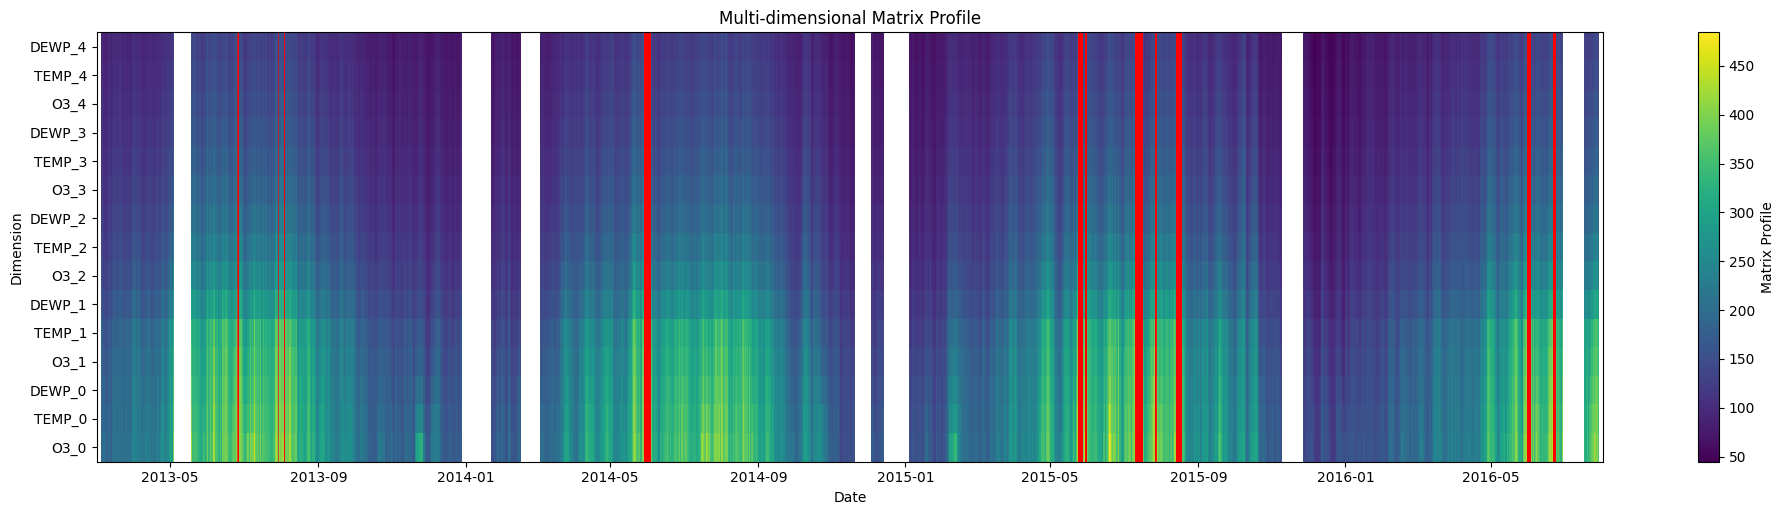


--- Cluster 2 (Window size : 168h) ---


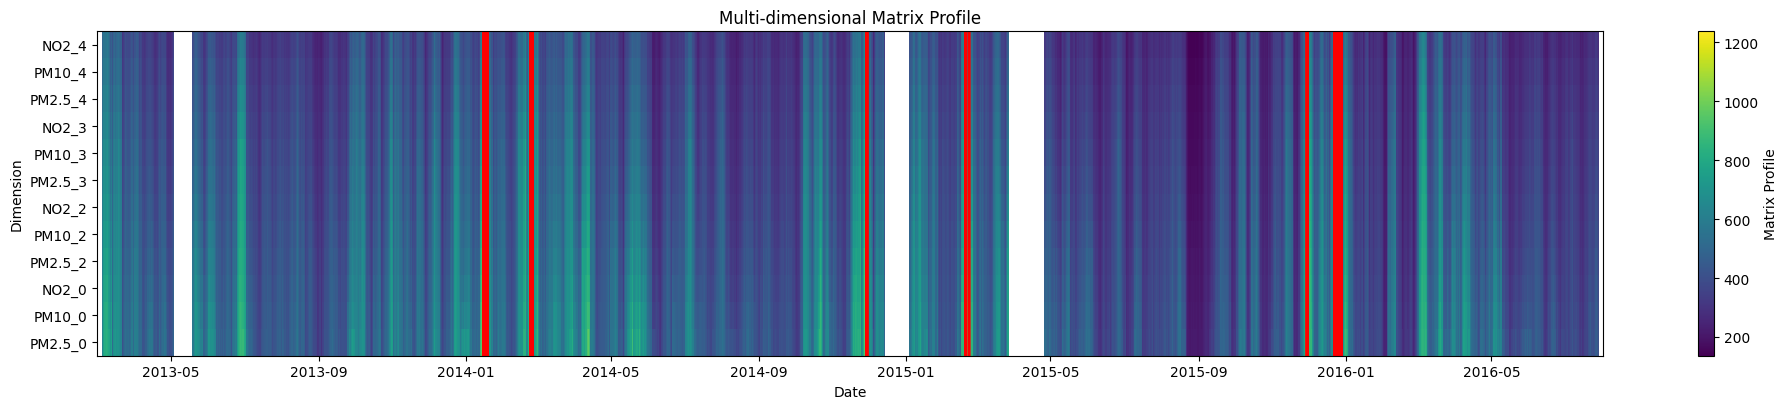

No motifs
No motifs


In [1]:
"""
Notebook - Matrix Profile Analysis using ampiimts (Python 3.11)

Goal:
From preprocessed signals (with original values, normalized values, window_size, clusters),
identify multi dimensional discords and motifs using a fixed-size sliding window based on the matrix profile method (stumpy.mstump).
"""

from ampiimts import ampiimts

folder = '../../dataset/air_bejin'

pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=30000,
                                                            top_k_cluster=2,
                                                            motif=False, 
                                                            group_size=16,
                                                            window_size="168h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=False,
                                                            smart_interpolation=False,
                                                            printunidimensional=False,
                                                            )



--- Cluster 1 (Window size : 168h) ---


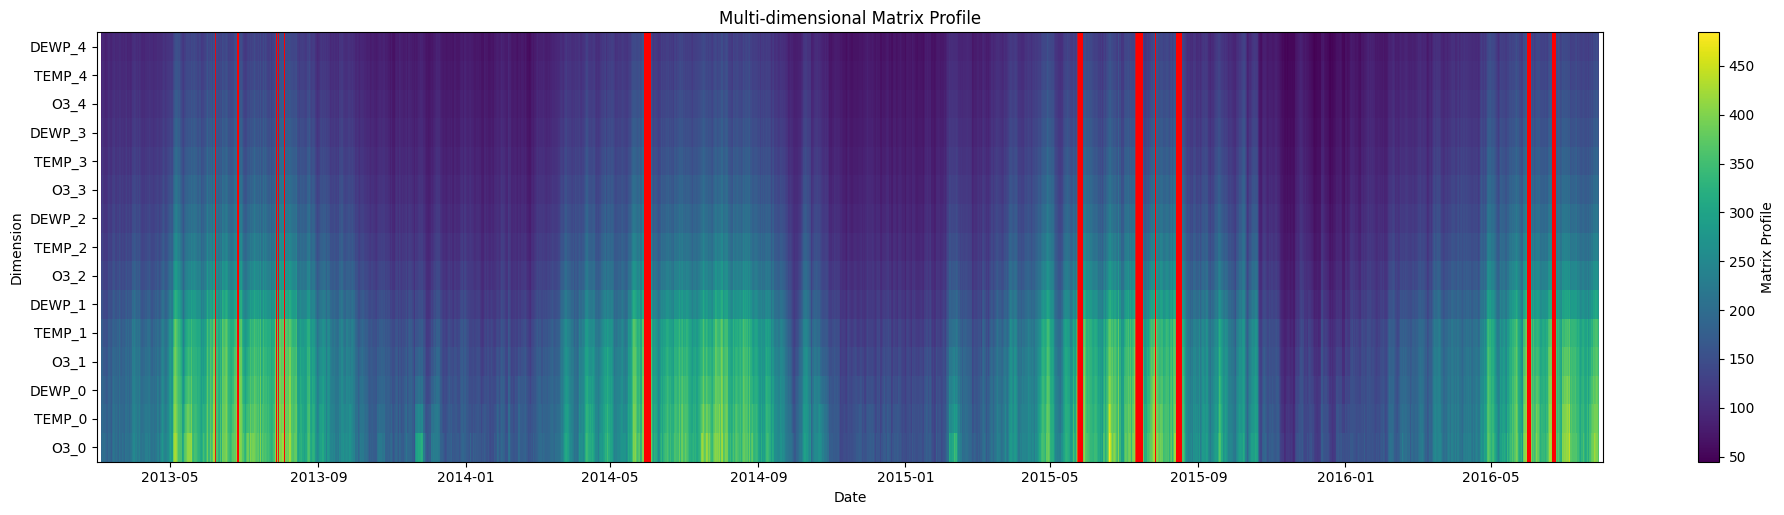


--- Cluster 2 (Window size : 168h) ---


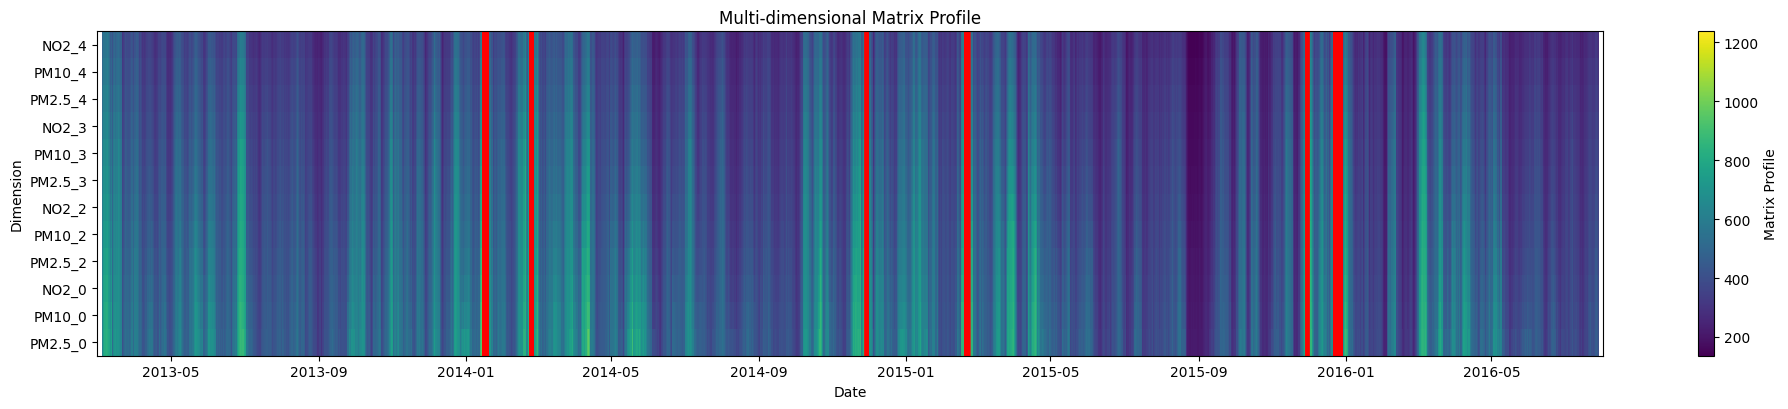

No motifs
No motifs


In [2]:
pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=30000,
                                                            top_k_cluster=2,
                                                            motif=False, 
                                                            group_size=16,
                                                            window_size="168h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=False,
                                                            smart_interpolation=True,
                                                            printunidimensional=False,
                                                            )




--- Cluster 1 (Window size : 168h) ---


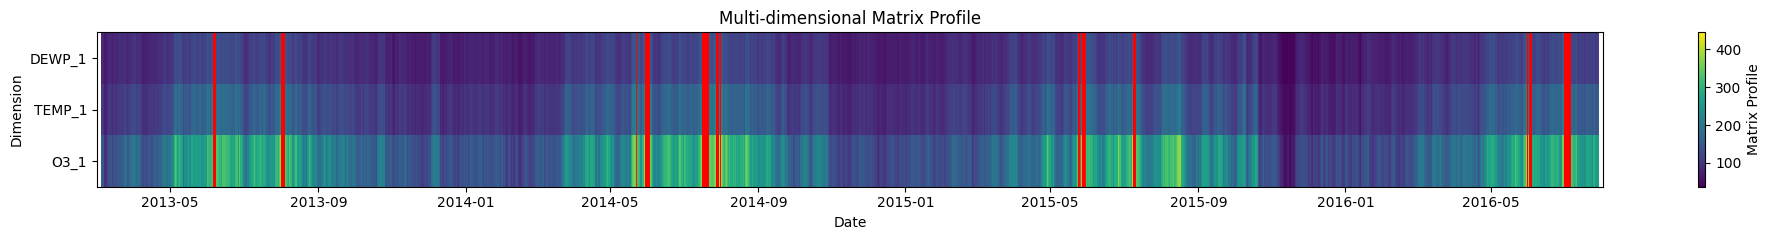


--- Cluster 2 (Window size : 168h) ---


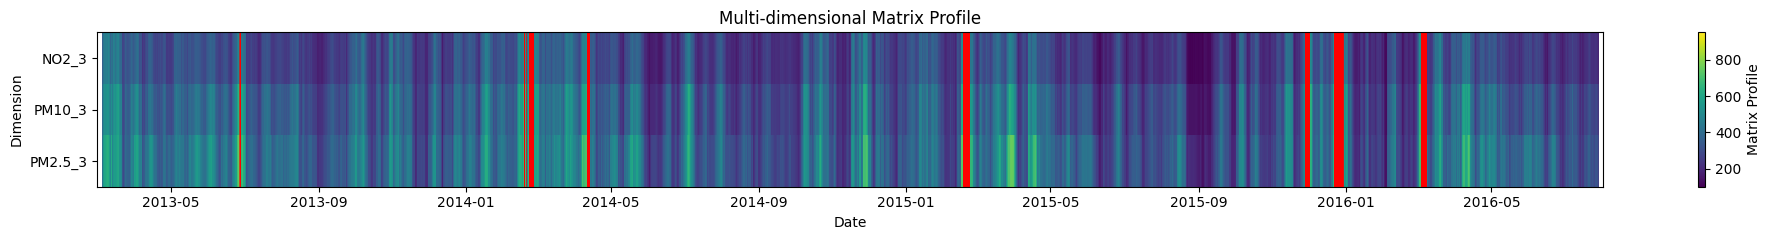

No motifs
No motifs


In [3]:
pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=30000,
                                                            top_k_cluster=2,
                                                            motif=False, 
                                                            group_size=16,
                                                            window_size="168h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=True,
                                                            smart_interpolation=True,
                                                            printunidimensional=False,
                                                            )




--- Cluster 1 (Window size : 56 days 06:00:00) ---


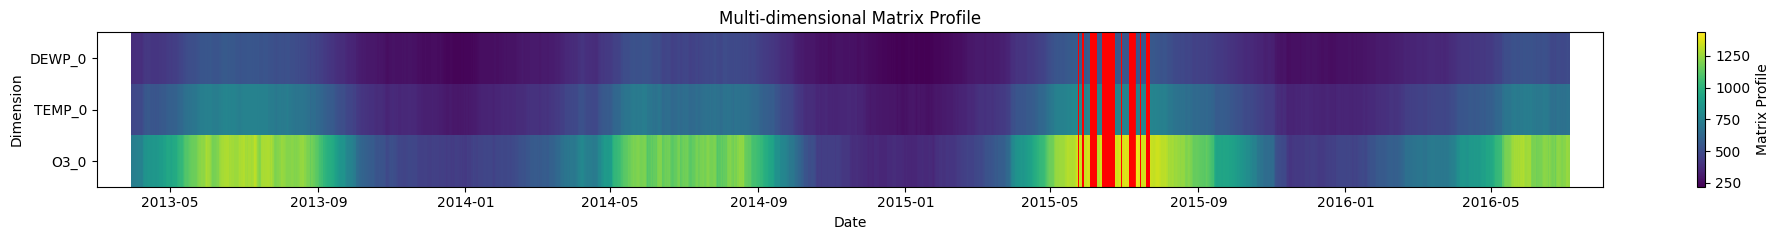


--- Cluster 2 (Window size : 0 days 11:00:00) ---


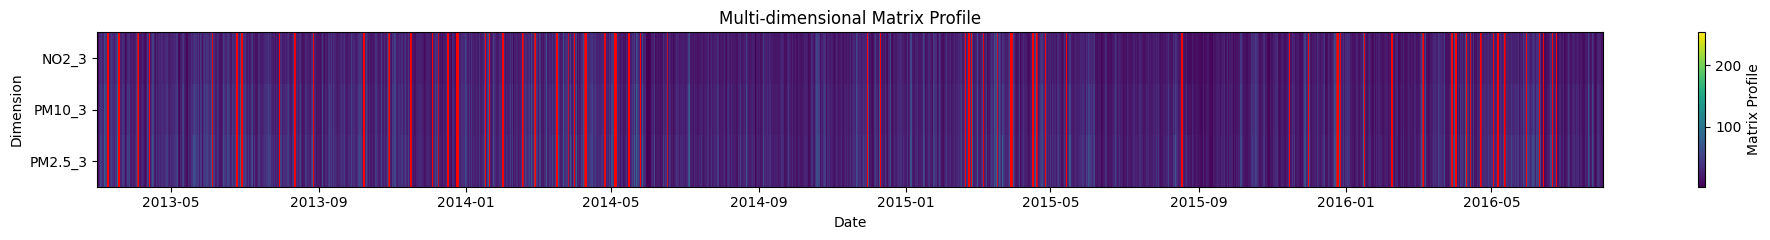

No motifs
No motifs


In [4]:
pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=30000,
                                                            top_k_cluster=2,
                                                            motif=False, 
                                                            group_size=16,
                                                            # window_size="168h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=True,
                                                            smart_interpolation=True,
                                                            printunidimensional=False,
                                                            )



--- Cluster 1 (Window size : 56 days 06:00:00) ---


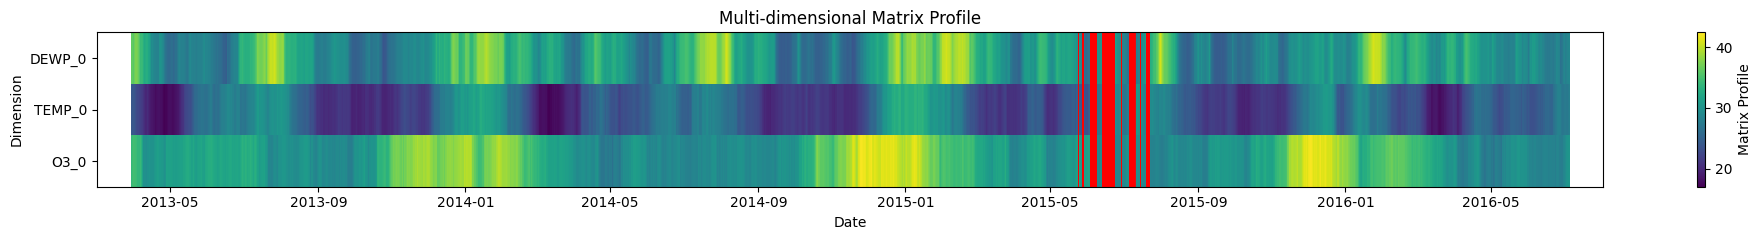


--- Cluster 2 (Window size : 0 days 11:00:00) ---


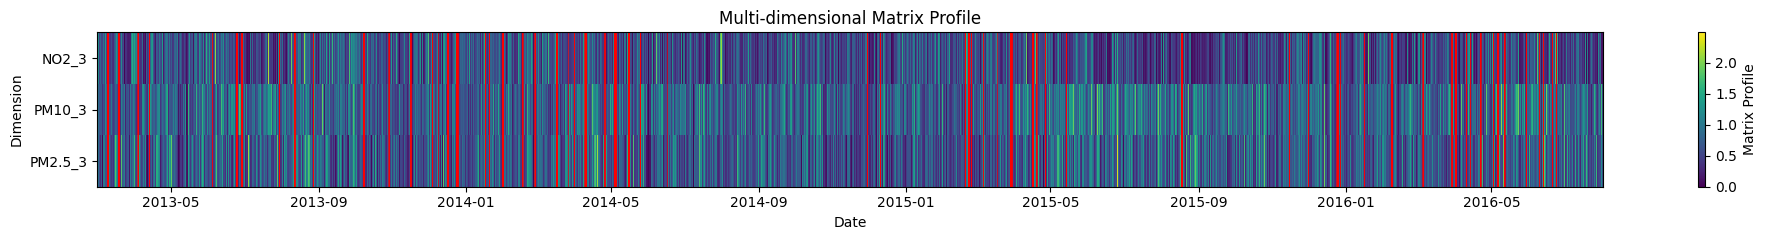

No motifs
No motifs


In [5]:
pds_interpolated, pds_normalized, matrix_profile = ampiimts(folder,
                                                            max_len=30000,
                                                            top_k_cluster=2,
                                                            motif=False, 
                                                            group_size=16,
                                                            # window_size="168h", 
                                                            display_info=False,
                                                            discord_top_pct=0.02,
                                                            most_stable_only=True,
                                                            smart_interpolation=True,
                                                            printunidimensional=True,
                                                            )
